## Importing Dependencies

In our [previous notebook](https://www.kaggle.com/amerii/spacenet-7-helper-functions) we programmed a few helper functions that made our lives much easier. Let's see how we are going to use those functions now to create our dataset class.

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import imgaug
import random


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
%matplotlib inline

In [4]:
im_path = Path('../data/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif')

In [5]:
with rio.open(im_path) as r:
    print(r.read().shape)

(4, 1023, 1024)


# [Dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

## (Work in Progress)

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

* `__len__` so that `len(dataset)` returns the size of the dataset.
* `__getitem__` to support the indexing such that `dataset[i]` can be used to get *ith* sample

Let’s create a dataset class for our dataset. We will read the [csv that we created in our previous notebook](https://www.kaggle.com/amerii/spacenet-7-directory-metadata-extraction), in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

### Retrieving the Satellite Image Samples

The sample that we are going to retrieve from our dataset will be retrieved in one of the 2 following ways:

* image_diff: The concatenated array of image1 and image2 that will be fed into our neural network
* date1 and date2: The dates that each of the satellite images were captured on
* im_dir: The parent image directory name
* mask_diff: The rasterized image of the change between the two ground truth polygons from both images
* blank_label: Boolean, indicating whether the output mask has a change or not. 



```sample = {'image_diff':image_diff_dict['chip'][chip_idx],
             'mask_diff':mask_diff_dict['chip'][chip_idx]
             'date1':date1,'date2':date2,
             'im_dir':img1_path.parent.parent,
             'blank_label':mask_diff_dict['blank'][chip_idx]}```

Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample.

Our dataset will also take another optional argument `chip_dimension` which specifies the dimensions of the output chips incase we want to segment our satellite image into smaller chips.
The chip dimension will be fed into our `ChipGenerator` Class, which creates chips out of the input satellite image.

In [6]:
def set_seed(seed=0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    imgaug.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [7]:
random.randint(0,100)

39

In [8]:
class MultiTemporalSatelliteDataset(Dataset):
    """SpaceNet 7 Multi-Temporal Satellite Imagery Dataset"""
    
    def __init__(self,csv_file, root_dir, no_udm=True, transform=None, chip_dimension=None):
        """
        Args:
            csv_file (Path): Path to the csv file with annotations
            root_dir (Path): Parent directory containing all other directories.
            no_udm (bool): Specifies whether the dataset will load UDM images or not.
            transform (callable, optional): Optional transform to be applied on a sample.
            chip_dimension (int, optional): Specifies the dimensions of the chip being generated.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.no_udm = no_udm
        self.transform = transform
        self.idx_combinations = self.__get_all_idx_combinations()
        self.chip_dimension = chip_dimension
        if self.chip_dimension is not None:
            self.chip_generator = self.__ChipGenerator(chip_dimension = self.chip_dimension)
            # this will be replaced later with an abstracted version
            # returns number of chips per image assuming all images are 1024
            self.n_chips = ((1024 - 1) // self.chip_dimension + 1)**2
            
    def __len__(self):
        if self.chip_dimension is not None:
            return len(self.idx_combinations)*self.n_chips
        else:
            return len(self.idx_combinations)
    
    def __getitem__(self,idx):
        if self.chip_dimension is not None:
            raster_idx = idx//self.n_chips
            chip_idx = idx%self.n_chips
        else:
            raster_idx = idx
            
        if torch.is_tensor(raster_idx):
            raster_idx = raster_idx.tolist()
        # get the indices of the 2 images
        idx1,idx2 = self.idx_combinations[raster_idx]
        # paths where the images are stored
        img1_path = self.root_dir/self.annotations.loc[idx1,'images_masked']
        img2_path = self.root_dir/self.annotations.loc[idx2,'images_masked']
        # paths where the corresponding true building footprints 
        labels1_path = self.root_dir/self.annotations.loc[idx1,'labels_match_pix']
        labels2_path = self.root_dir/self.annotations.loc[idx2,'labels_match_pix']
        # read rasters using imported rasterio library
        with rio.open(img1_path) as r1, rio.open(img2_path) as r2:
            raster1 = r1.read()[0:3]  
            raster2 = r2.read()[0:3]
        # get the concatenated array of the 2 images that will be fed into the neural_net
        raster_diff = np.concatenate((raster1,raster2),axis=0)
        # get the dates for the images
        date1 = tuple(self.annotations.loc[idx1,['month','year']])
        date2 = tuple(self.annotations.loc[idx2,['month','year']])
        # read geojson files for each of the satellite images into a geodataframe
        gdf1 = gpd.read_file(labels1_path).set_index('Id').sort_index()
        gdf2 = gpd.read_file(labels2_path).set_index('Id').sort_index()
        # get the change between the 2 satellite images by comparing their polygons
        gdf_diff = self.__geo_difference(labels1_path,labels2_path)
        # get the corresponding rasterized image of the geodataframes
        mask_diff = self.__rasterize_gdf(gdf_diff,out_shape=raster1.shape[1:3])
        
        if self.chip_dimension:
            raster_diff_dict = self.chip_generator(raster_diff)
            mask_diff_dict = self.chip_generator(mask_diff)

            sample = {'raster_diff':raster_diff_dict['chip'][chip_idx],'date1':date1,'date2':date2,
          'mask_diff':mask_diff_dict['chip'][chip_idx],'im_dir':str(img1_path.parent.parent),'blank_label':mask_diff_dict['blank'][chip_idx]}
        
        else:
            sample = {'raster_diff':raster_diff,'date1':date1,'date2':date2,'mask_diff':mask_diff,'im_dir':str(img1_path.parent.parent)}
        
        if self.transform is not None:
            # get the individual images and mask from the output sample
            raster1 = np.moveaxis(np.uint8(sample['raster_diff'][:3]),0,-1)
            raster2 = np.moveaxis(np.uint8(sample['raster_diff'][3:6]),0,-1)
            mask = np.moveaxis(np.uint8(sample['mask_diff']),0,-1)
            
            seed = random.randint(0,1000)
            set_seed(seed)
            
            # apply transform on first image and mask
            transformed = self.transform(image=raster1,mask=mask)
            raster1 = transformed['image']
            mask_diff = transformed['mask']
            
            set_seed(seed)
            
            # apply transform on second image
            raster2 = self.transform(image=raster2)['image']
            # concatenate input images
            raster_diff = torch.cat((raster1,raster2))
            # update sample dictionary paramters after transformation
            if not isinstance(raster_diff,np.ndarray):
                sample['raster_diff'] = raster_diff
                mask_diff = mask_diff.permute(2,0,1)
                sample['mask_diff'] = mask_diff
            else:
                sample['raster_diff'] = raster_diff
                mask_diff = np.moveaxis(mask_diff,-1,0)
                sample['mask_diff'] = mask_diff
            
        return sample
    
    def __get_all_idx_combinations(self):
        all_combinations = []
        # group by satellite image location
        location_groups = self.annotations.groupby('image_dir_name')
        # loop through the groups and get the different index combinations
        for i,location in enumerate(location_groups):
            # get the dataframe in the group
            loc_frame = location[1]
            # make sure that list does not contain images with unidentified masks
            condition = (loc_frame['has_udm'] == False)
            # return a list of the indices in the location dataframe
            l = list(loc_frame[condition].index)
            # use itertools to get all the different combinations between 2 in the list
            combinations = list(itertools.combinations(l,2))
            all_combinations.extend(combinations)
        return all_combinations
        
    def __geo_difference(self,geojson1,geojson2):
        # read geojson into geodataframes
        gdf1 = gpd.read_file(geojson1).set_index('Id').sort_index()
        gdf2 = gpd.read_file(geojson2).set_index('Id').sort_index()

        # get geodataframe lengths
        len_1 = len(gdf1)
        len_2 = len(gdf2)
        # check which gdf is longer
        len_diff = abs(len_2-len_1)

        if len_2 > len_1:
            start_index = len_2-len_diff
            diff_gdf = gdf2.iloc[start_index:].copy()
        else:
            start_index = len_1-len_diff
            diff_gdf = gdf1.iloc[start_index:].copy()

        # reset the index
        diff_gdf.reset_index(inplace=True,drop=True)

        return diff_gdf

    
    def __rasterize_gdf(self,gdf,out_shape):
        # if geodataframe is empty return empty mask
        if len(gdf)==0:
            return np.zeros((1,*out_shape))
            
        mask = features.rasterize(((polygon, 255) for polygon in gdf['geometry']),out_shape=out_shape)
        
        return np.expand_dims(mask,axis=0)
    
    class __ChipGenerator():   
        def __init__(self, chip_dimension=256,return_raster=False):  
            self.chip_dimension = chip_dimension
            self.return_raster = return_raster
            self.chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

        def __call__(self,raster):
            np_array = self.__read_raster(raster)
            # get number of chips per colomn
            n_rows = (np_array.shape[1] - 1) // self.chip_dimension + 1
            # get number of chips per row
            n_cols = (np_array.shape[2] - 1) // self.chip_dimension + 1
            # segment image into chips and return dict of chips and metadata
            chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

            for r in range(n_rows):
                for c in range(n_cols):
                    start_r_idx = r*self.chip_dimension
                    end_r_idx = start_r_idx + self.chip_dimension

                    start_c_idx = c*self.chip_dimension
                    end_c_idx = start_c_idx + self.chip_dimension
                    
                    chip = np_array[:,start_r_idx:end_r_idx,start_c_idx:end_c_idx]

                    chip_dict['chip'].append(chip)
                    chip_dict['x'].append(start_r_idx)
                    chip_dict['y'].append(start_c_idx)
                    
                    # Check if the chip is an empty chip
                    if chip.mean() == 0 and chip.sum() == 0:
                        chip_dict['blank'].append(1)
                    else:
                        chip_dict['blank'].append(0)

            return chip_dict

        def __read_raster(self,raster):
            # check whether raster is a path or array
            if isinstance(raster,(pathlib.PurePath,str)):
                    with rio.open(raster) as r:
                        # convert raster into np array
                        np_array = r.read()
                    return np_array

            elif isinstance(raster,np.ndarray):
                return raster
            else:
                raise ValueError(f"Expected Path or Numpy array received: {type(raster)}")  

In [35]:
''' ToDo:
Need to update function below to make it more similar to torchvision.utils.make_grid() method
The final output will be 3 images:
The stacked before images
The stacked after images
The stacked difference images
'''
def plot_sample(d,dpi=300,show=True):
    # convert torch tensor to numpy array
    if isinstance(d['raster_diff'],torch.Tensor):
        raster_diff = d['raster_diff'].numpy()
        mask_diff = d['mask_diff'].numpy()
    else:
        raster_diff = d['raster_diff']
        mask_diff = d['mask_diff']
        
    # make sure channels are in the correct order for plotting
    if d['raster_diff'].shape[0] <= 6:
        image1 = np.moveaxis(raster_diff[0:3],0,-1)
        image2 = np.moveaxis(raster_diff[3:6],0,-1)
        mask_diff = np.moveaxis(mask_diff,0,-1).squeeze()
    else:
        image1 = d['raster_diff'][0:3]
        image2 = d['raster_diff'][3:6]
        
    images = [image1,image2,mask_diff]
    
    mpl.rcParams['figure.dpi'] = dpi
    ncols = 3
    fig,axs = plt.subplots(1,ncols,figsize=(10,10))
    fig.tight_layout()
    #plt.tick_params(axis = 'both', which = None, bottom = None, top = None) 
    
    date1 = d['date1']
    date2 = d['date2']
    titles = [d['date1'],d['date2'],'difference']
    
    

    for n in range(ncols):
        axs[n].set_title(titles[n])
        axs[n].imshow(images[n])
    
    if show:
        plt.show()
    else:
        return axs

### Paths to Directories and Files
The csv file that we are going to be using to load the data into our dataset was [created in one of our previous notebooks](https://www.kaggle.com/amerii/spacenet-7-directory-metadata-extraction). The data is formatted in such a way that we can easily access the files we want.

In [36]:
root_dir = Path('../data/train/')
csv_file = Path('../data/output_csvs/df_train_untidy.csv')

In [37]:
df = pd.read_csv(csv_file)

In [38]:
df.head()

parent_dir                image_dir_name  \
0      train  L15-0760E-0887N_3041_4643_13   
1      train  L15-0760E-0887N_3041_4643_13   
2      train  L15-0760E-0887N_3041_4643_13   
3      train  L15-0760E-0887N_3041_4643_13   
4      train  L15-0760E-0887N_3041_4643_13   

                                               fname  year  month  has_udm  \
0  global_monthly_2019_08_mosaic_L15-0760E-0887N_...  2019      8    False   
1  global_monthly_2019_02_mosaic_L15-0760E-0887N_...  2019      2    False   
2  global_monthly_2018_10_mosaic_L15-0760E-0887N_...  2018     10    False   
3  global_monthly_2018_04_mosaic_L15-0760E-0887N_...  2018      4    False   
4  global_monthly_2018_12_mosaic_L15-0760E-0887N_...  2018     12    False   

  udm_masks                                             images  \
0       NaN  L15-0760E-0887N_3041_4643_13/images/global_mon...   
1       NaN  L15-0760E-0887N_3041_4643_13/images/global_mon...   
2       NaN  L15-0760E-0887N_3041_4643_13/images/global_mon...   
3       NaN  L15-0760E-0887N_3041_4643_13/images/global_mon...   
4       NaN  L15-0760E-0887N_3041_4643_13/images/global_mon...   

                                       images_masked  \
0  L15-0760E-0887N_3041_4643_13/images_masked/glo...   
1  L15-0760E-0887N_3041_4643_13/images_masked/glo...   
2  L15-0760E-0887N_3041_4643_13/images_masked/glo...   
3  L15-0760E-0887N_3041_4643_13/images_masked/glo...   
4  L15-0760E-0887N_3041_4643_13/images_masked/glo...   

                                    labels_buildings  \
0  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
1  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
2  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
3  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
4  L15-0760E-0887N_3041_4643_13/labels/global_mon...   

                                          labels_udm  \
0  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
1  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
2  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
3  L15-0760E-0887N_3041_4643_13/labels/global_mon...   
4  L15-0760E-0887N_3041_4643_13/labels/global_mon...   

                                        labels_match  \
0  L15-0760E-0887N_3041_4643_13/labels_match/glob...   
1  L15-0760E-0887N_3041_4643_13/labels_match/glob...   
2  L15-0760E-0887N_3041_4643_13/labels_match/glob...   
3  L15-0760E-0887N_3041_4643_13/labels_match/glob...   
4  L15-0760E-0887N_3041_4643_13/labels_match/glob...   

                                    labels_match_pix  
0  L15-0760E-0887N_3041_4643_13/labels_match_pix/...  
1  L15-0760E-0887N_3041_4643_13/labels_match_pix/...  
2  L15-0760E-0887N_3041_4643_13/labels_match_pix/...  
3  L15-0760E-0887N_3041_4643_13/labels_match_pix/...  
4  L15-0760E-0887N_3041_4643_13/labels_match_pix/...

## Utilizing our Dataset Object

In [39]:
train_set = MultiTemporalSatelliteDataset(root_dir=root_dir,csv_file=csv_file)

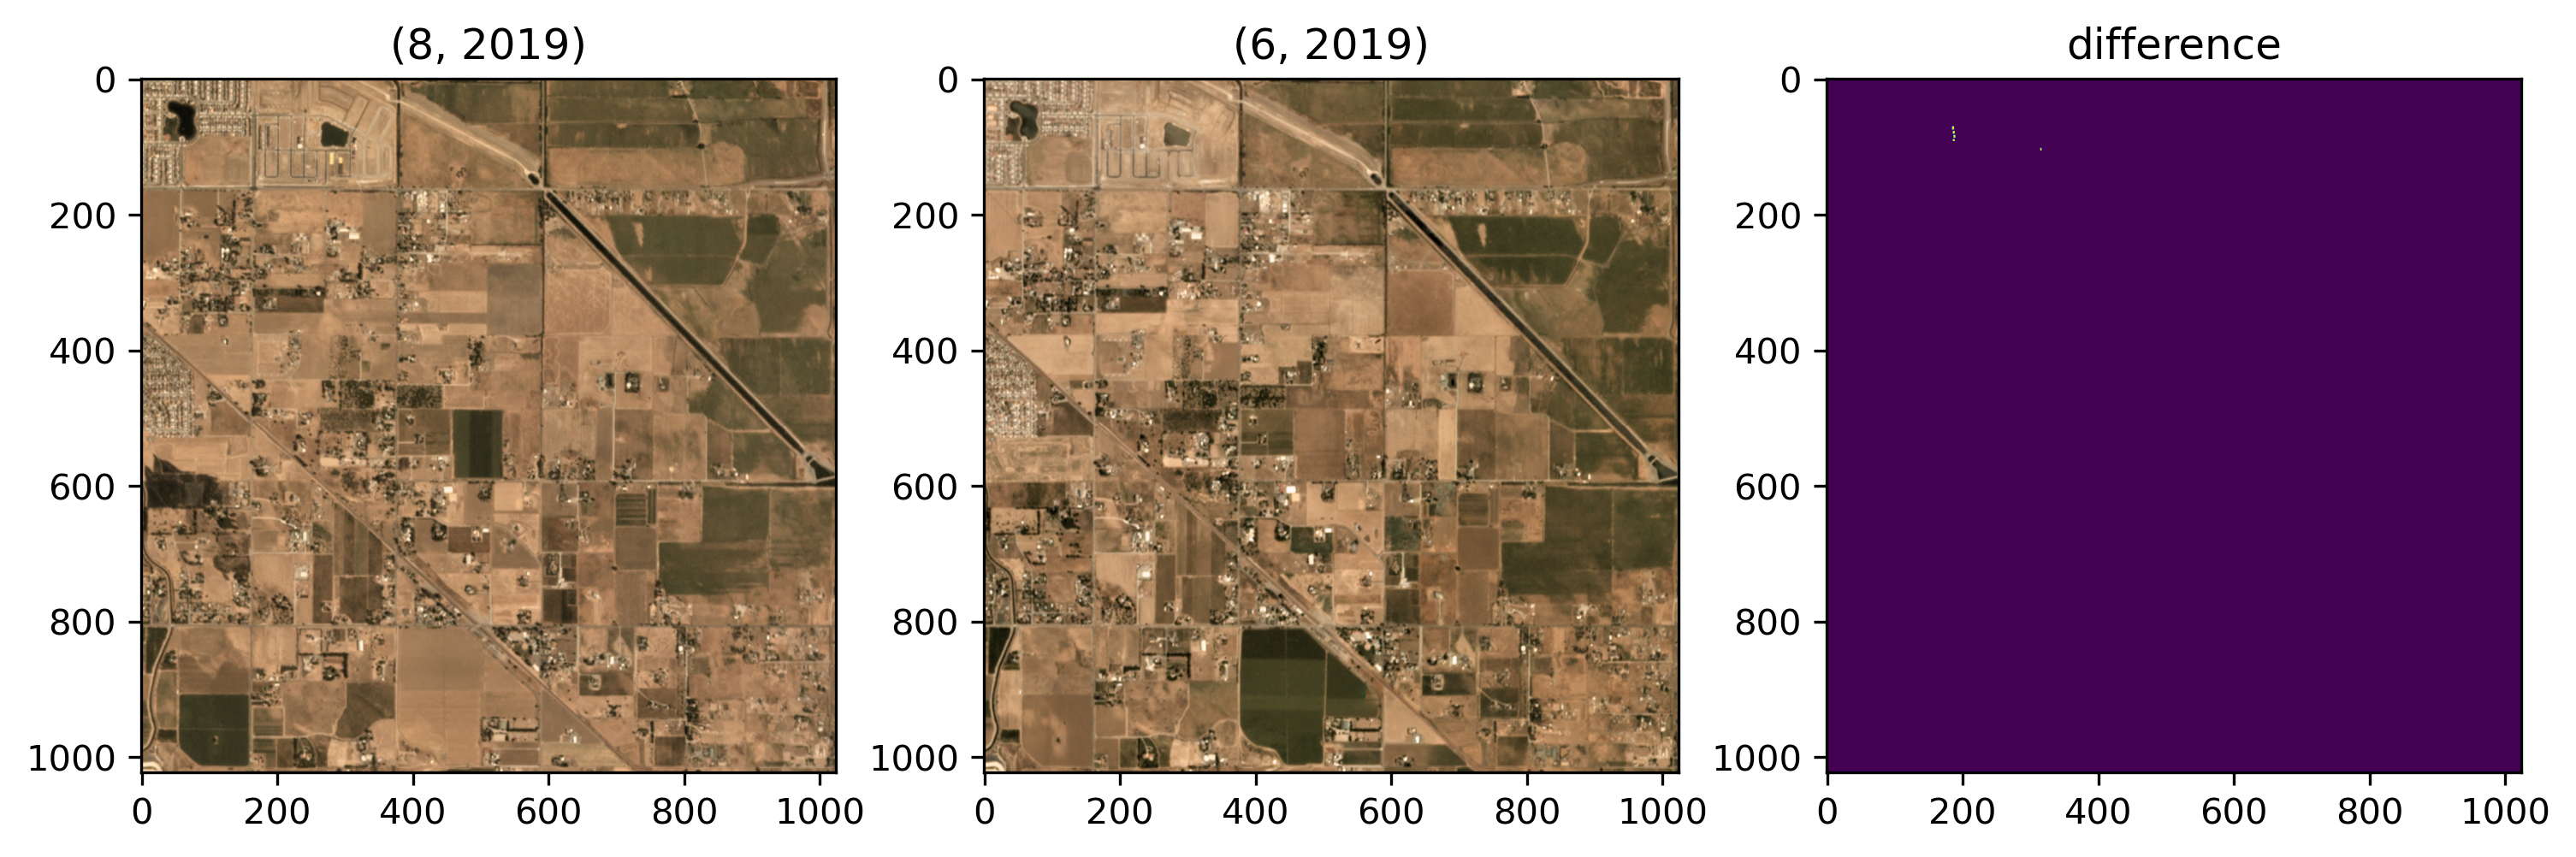

In [41]:
plot_sample(train_set[6])

In [42]:
train_set_512 = MultiTemporalSatelliteDataset(root_dir=root_dir,csv_file=csv_file,chip_dimension=512)

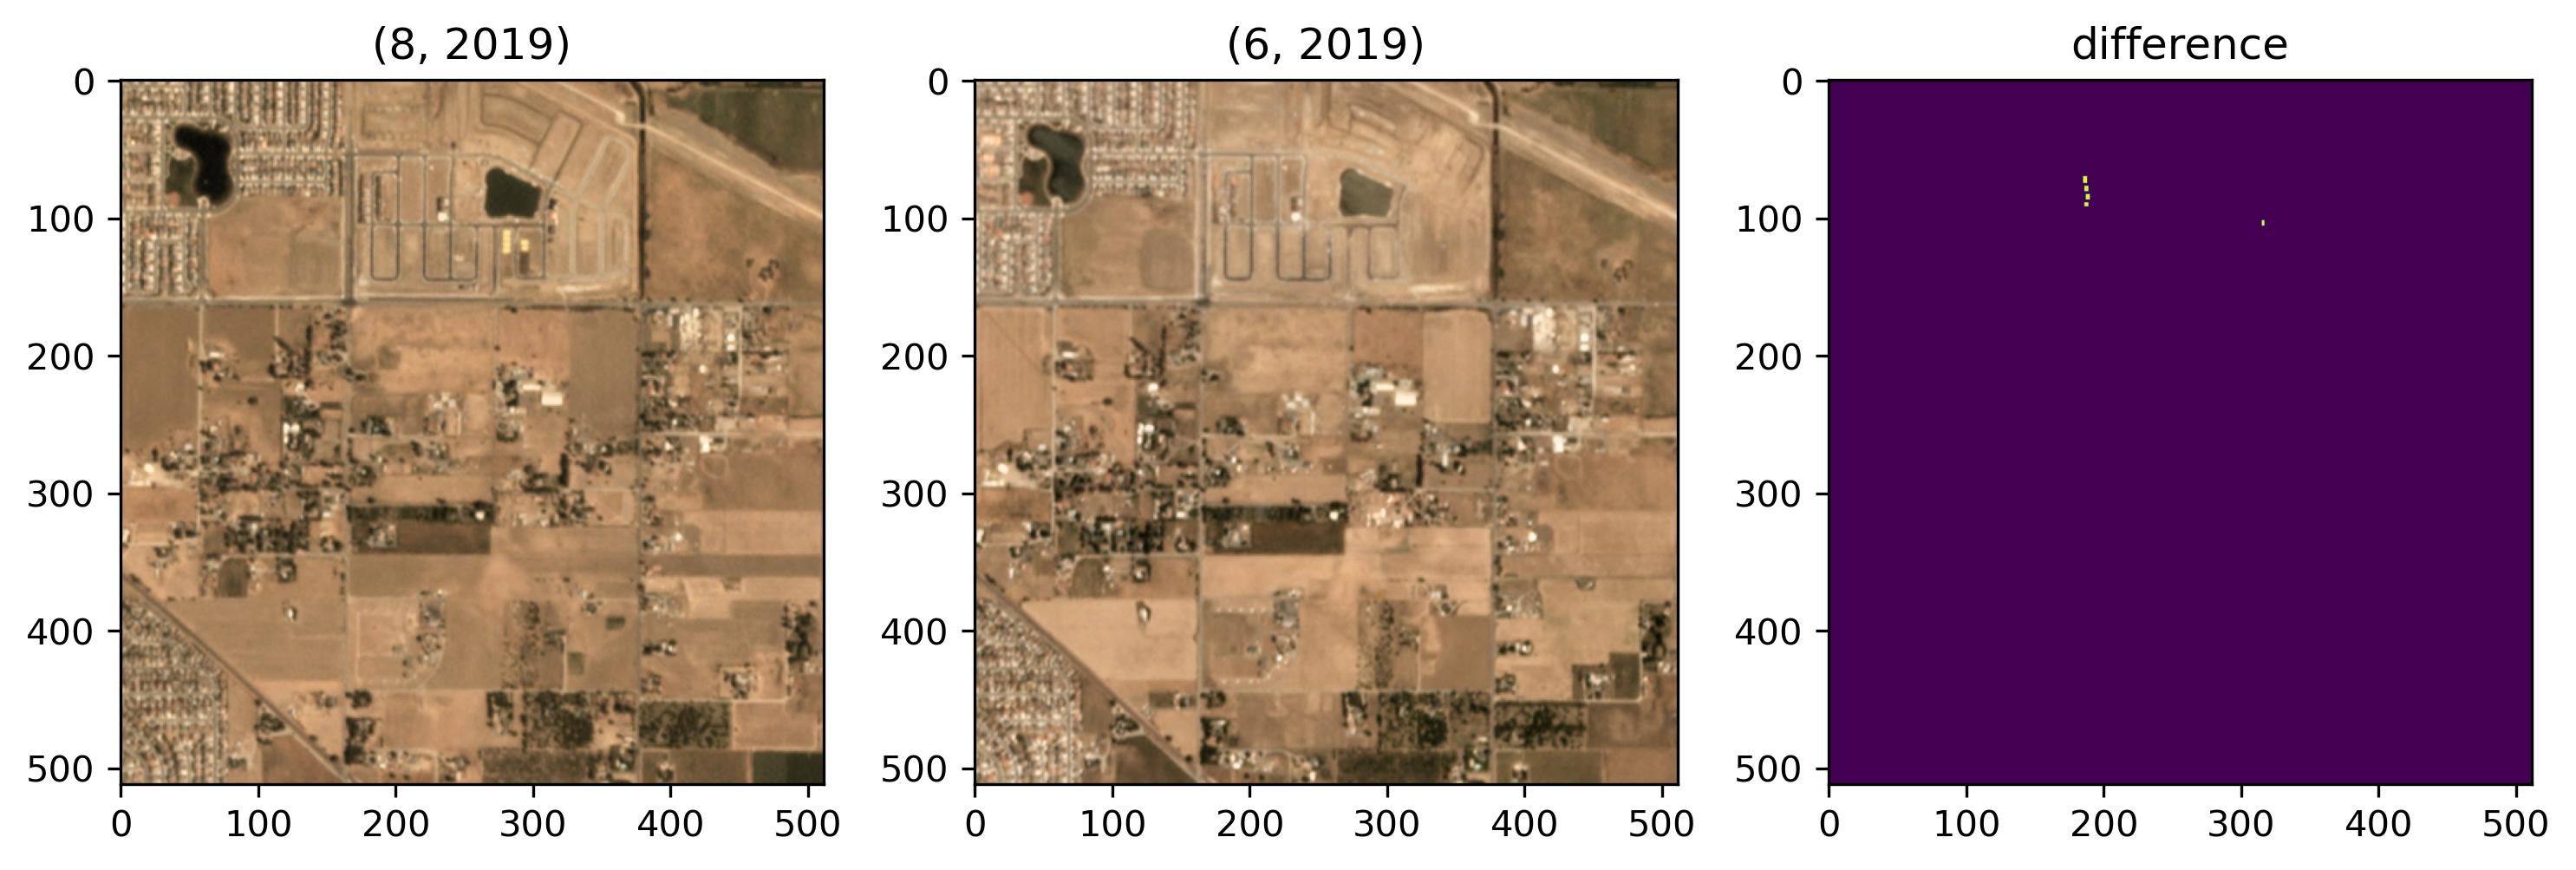

In [43]:
plot_sample(train_set_512[24])

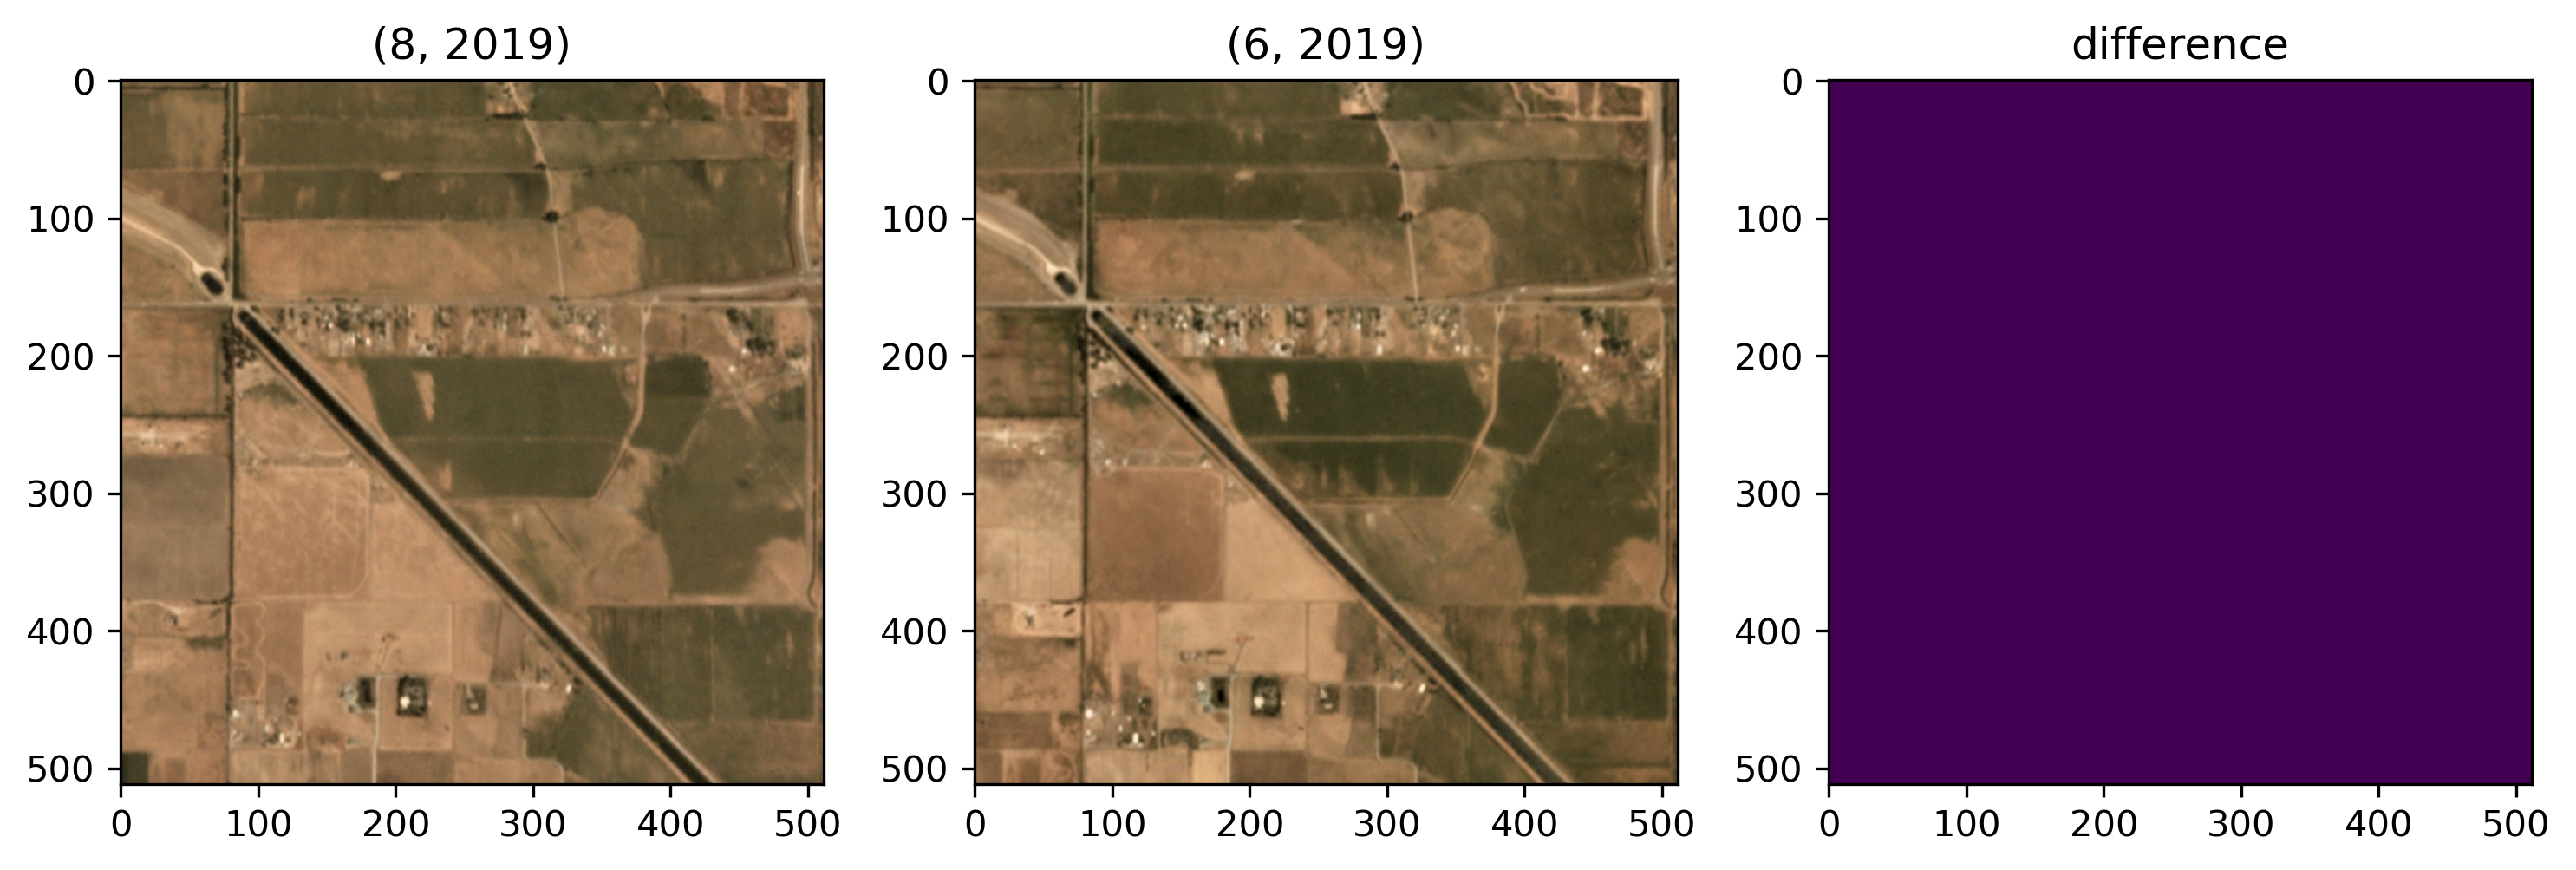

In [44]:
plot_sample(train_set_512[25])

# Transforms (Work in Progress)

In [45]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample

In [46]:
class AsImage(object):
    """Convert shape of image from (Channels,Rows,Columns) to (Rows,Column,Channels)."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample

In [50]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# DataLoader (Work in Progress)

```
A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
A.Rotate(limit=(-360, 360), interpolation=4, border_mode=4,p=0),
```

In [51]:
chip_dimension = 64

In [52]:
transform = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=1),
        A.RandomRotate90(p=1.0),
        ToTensorV2()
    ]
)

In [53]:
train_set_64 = MultiTemporalSatelliteDataset(root_dir=root_dir,csv_file=csv_file,chip_dimension=chip_dimension,transform=transform)

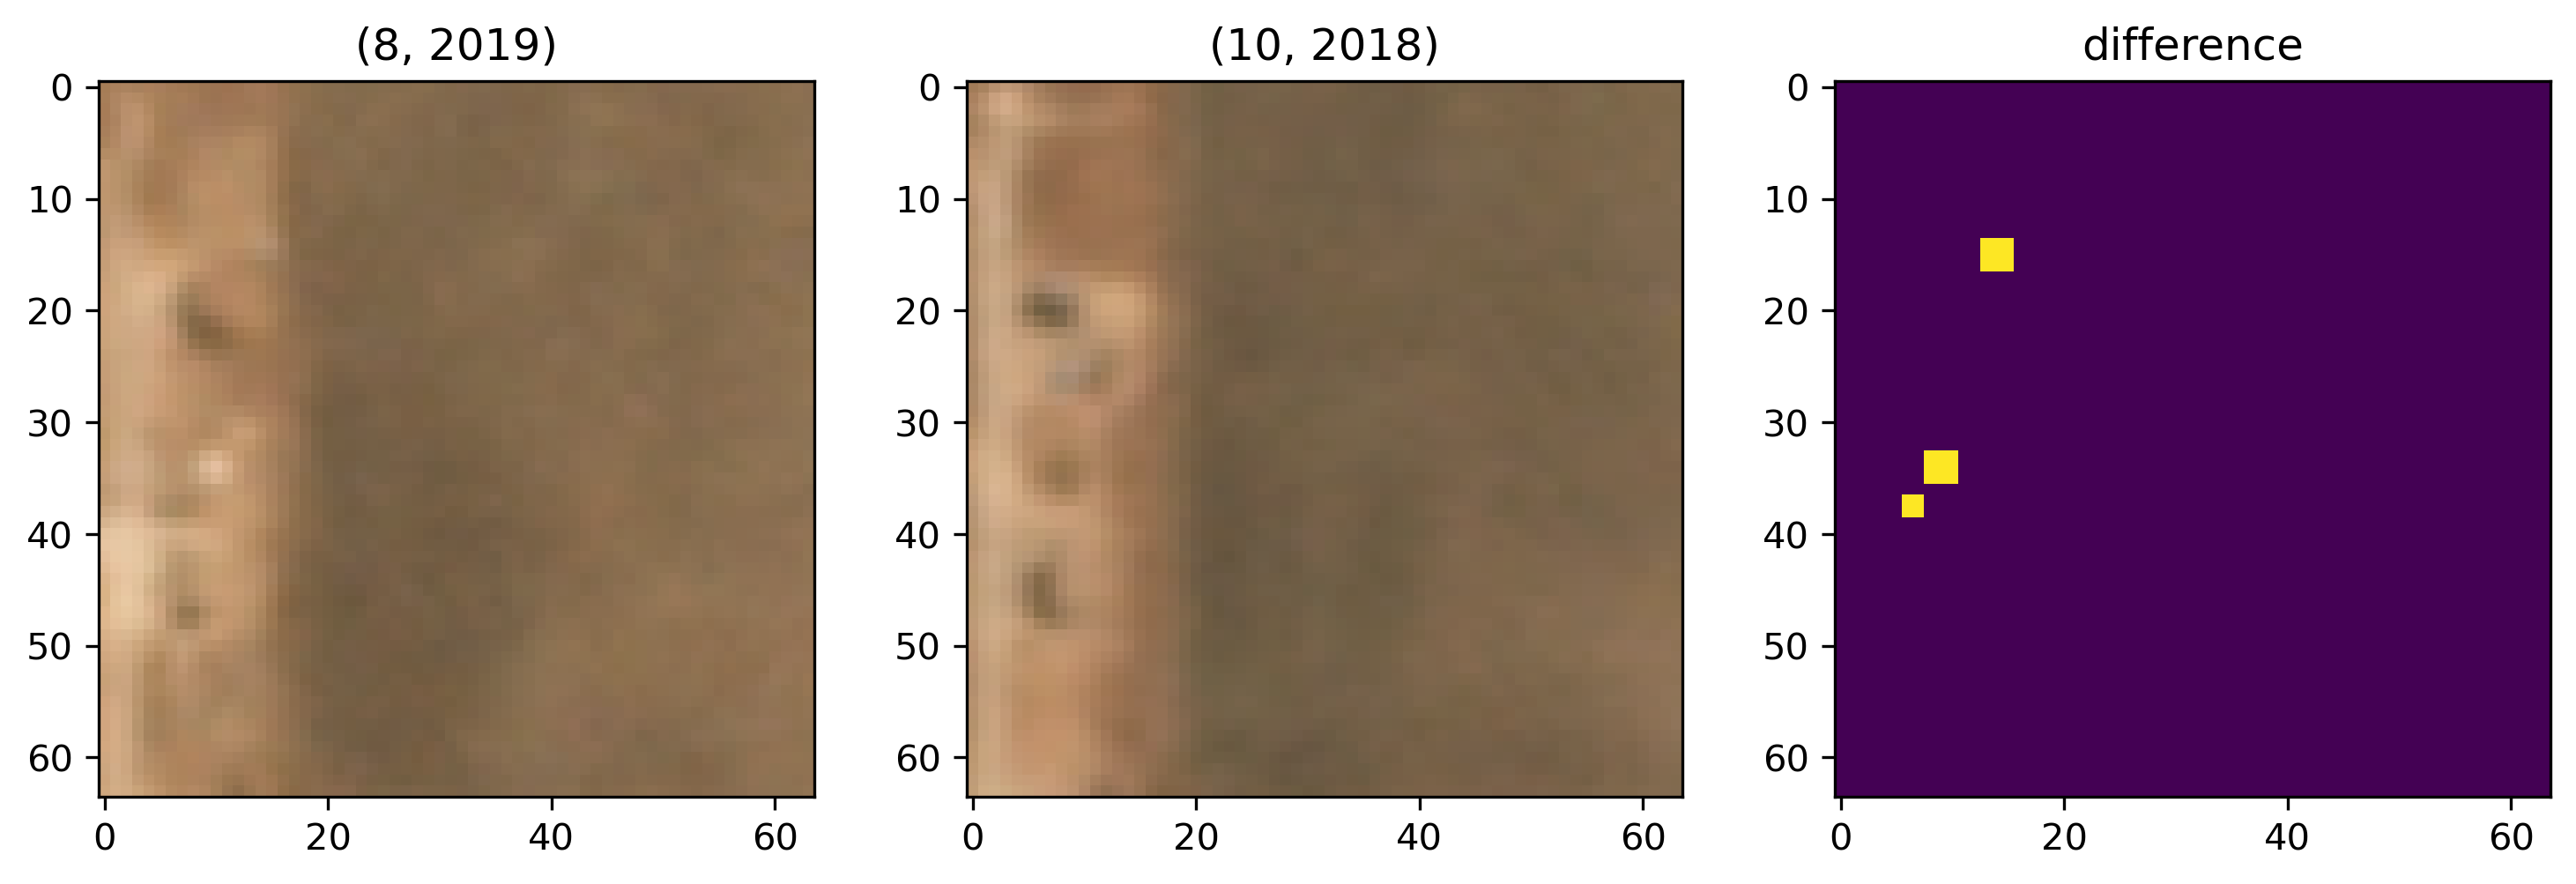

In [54]:
plot_sample(train_set_64[328])

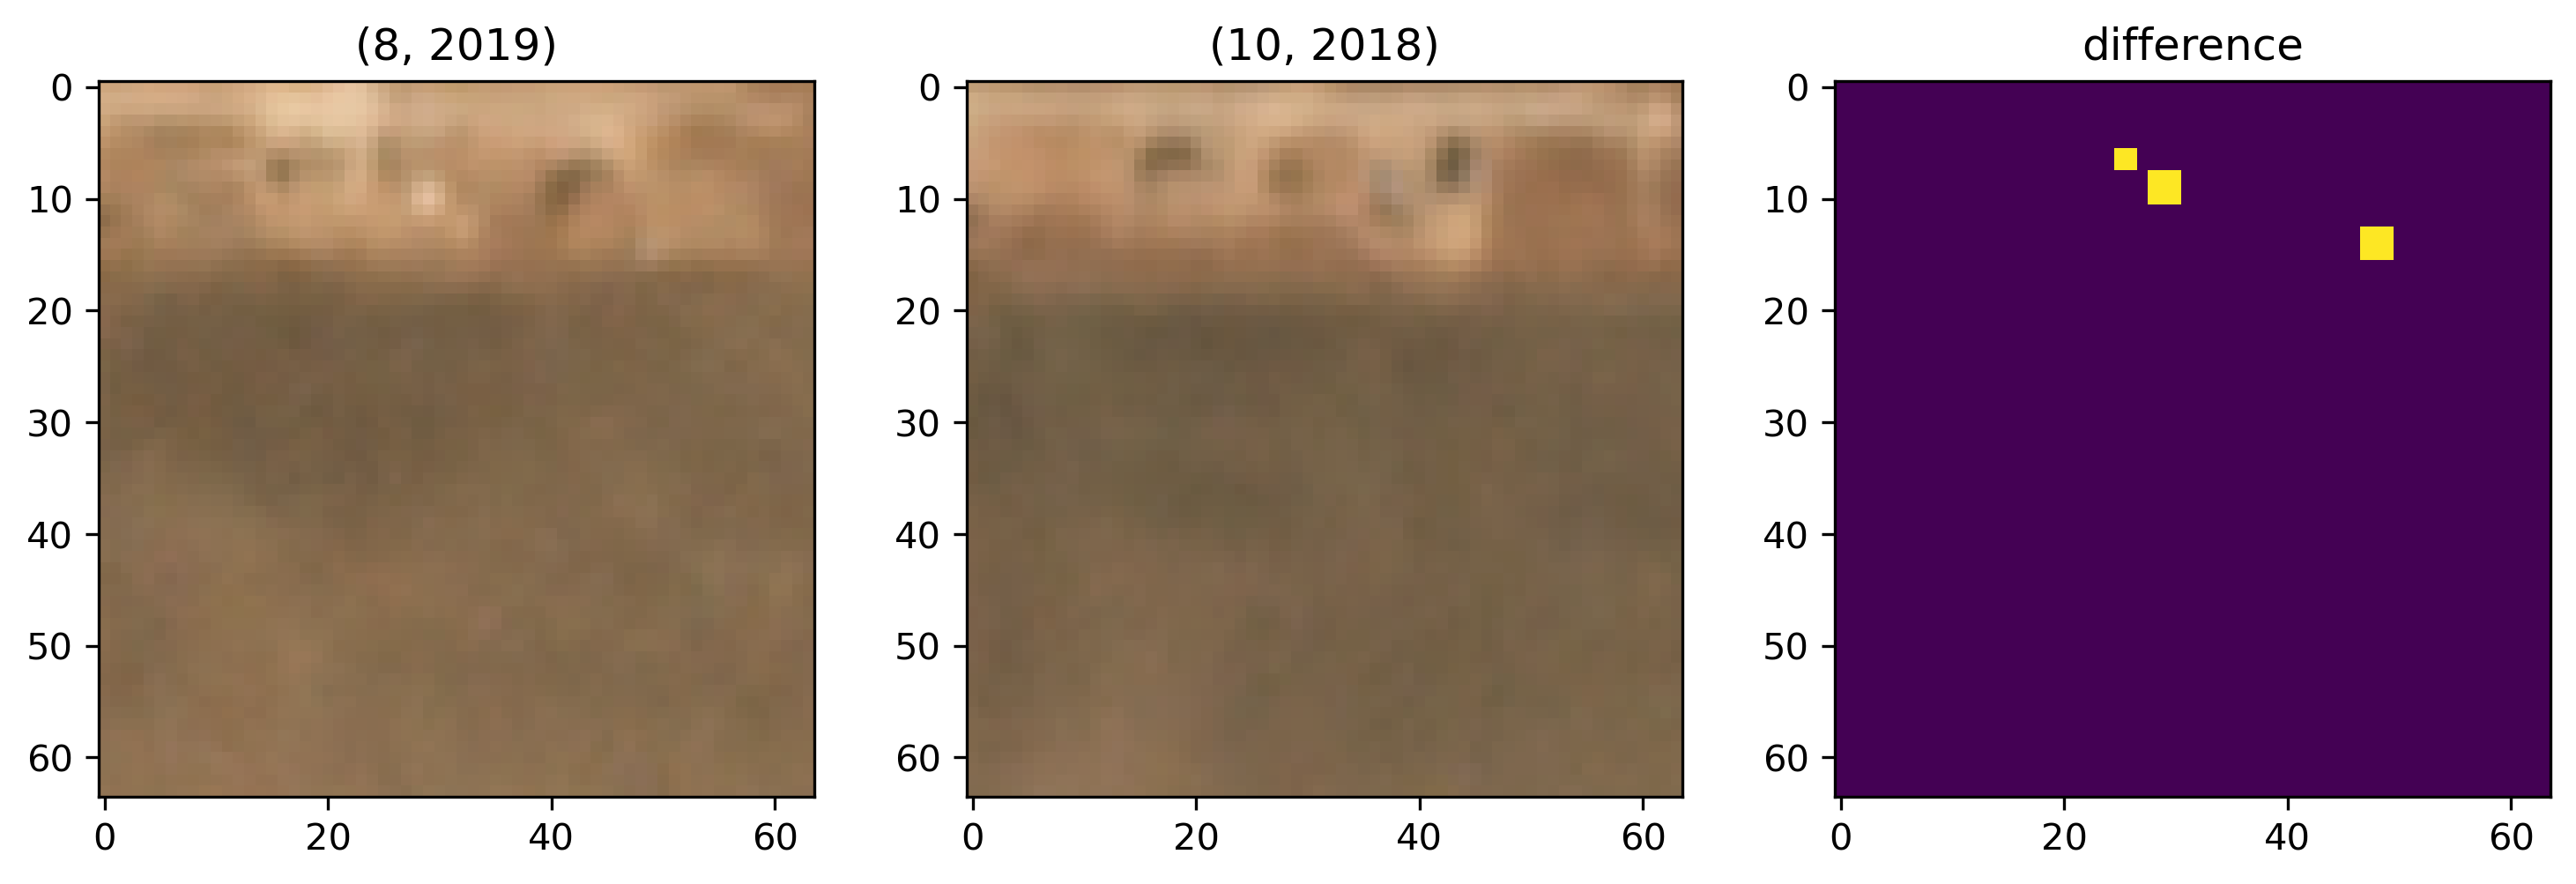

In [55]:
plot_sample(train_set_64[328])

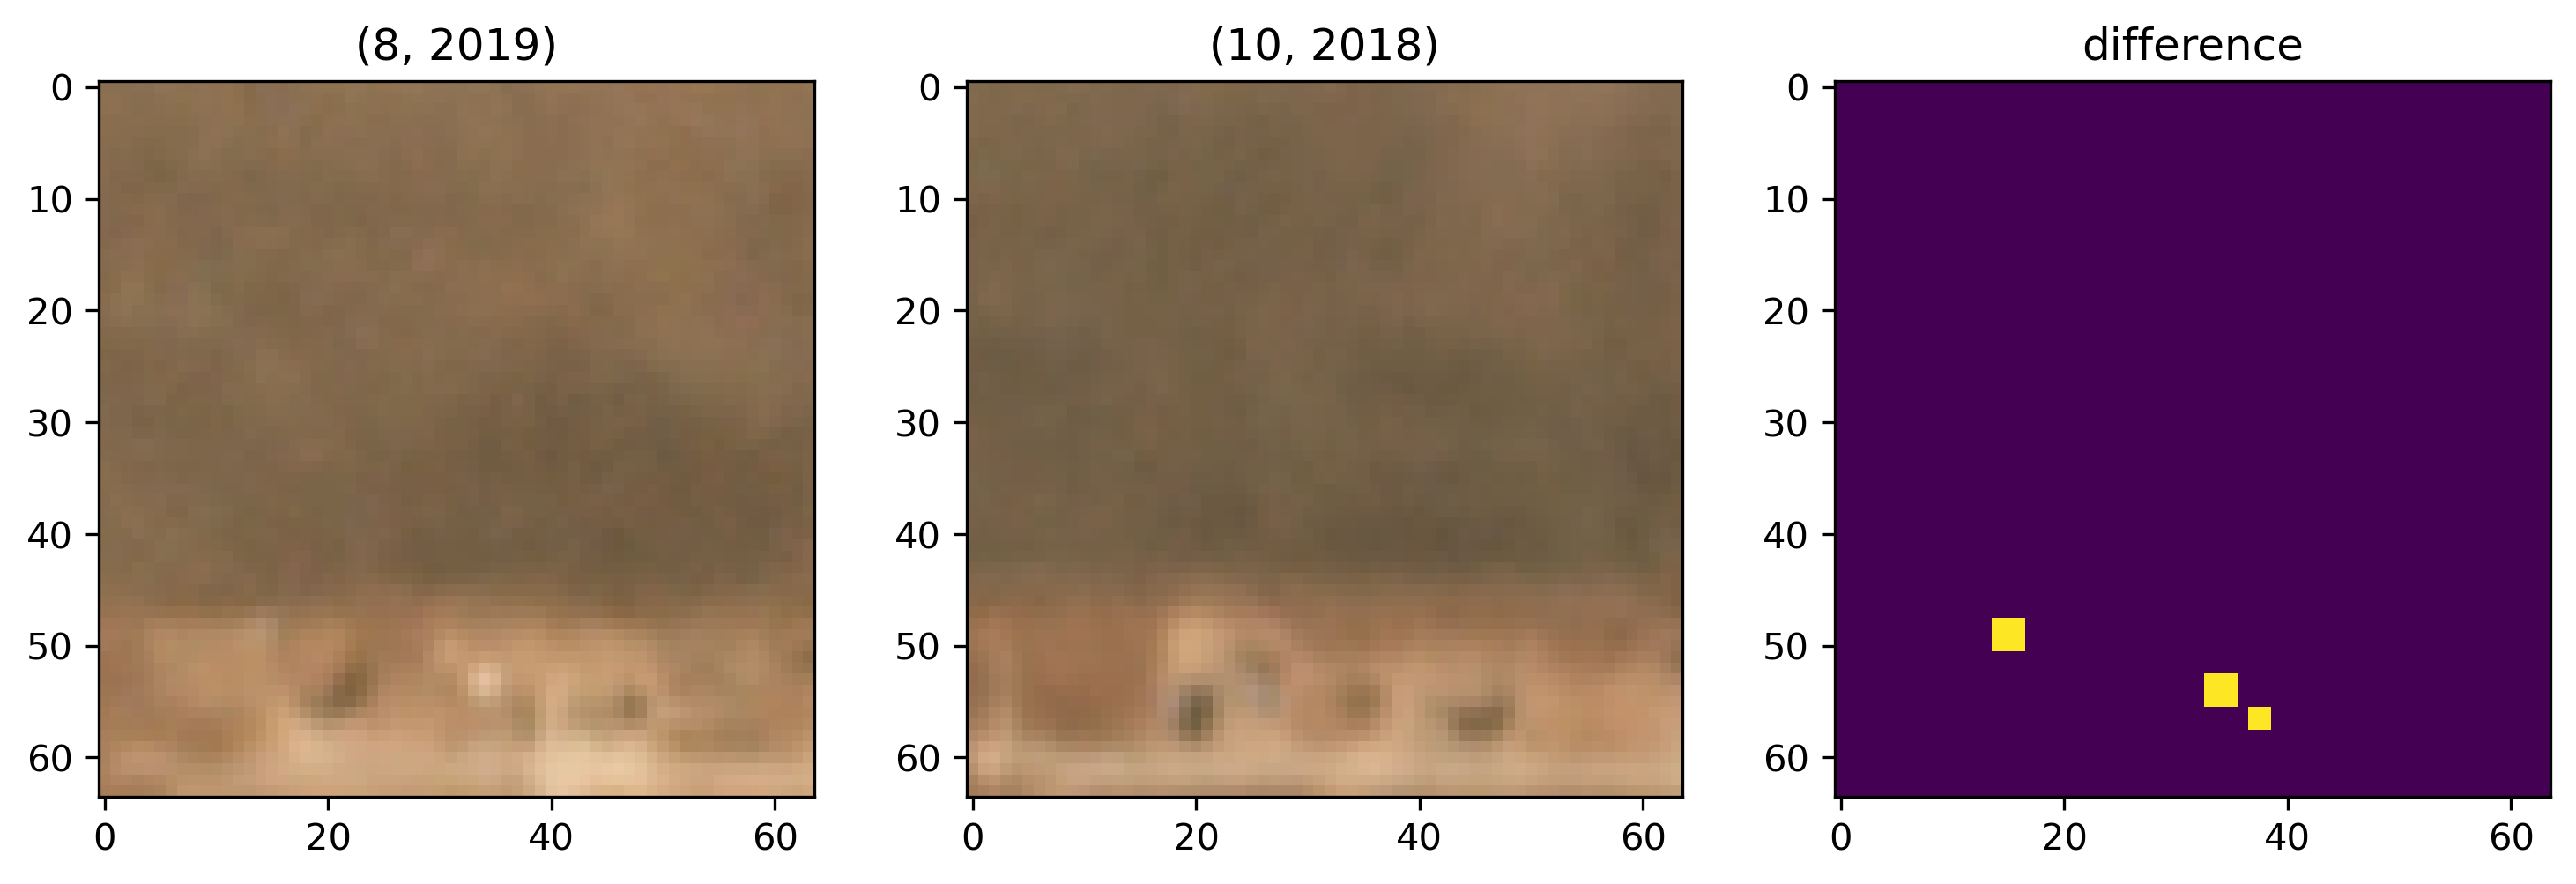

In [56]:
plot_sample(train_set_64[328])

In [57]:
dataloader = DataLoader(train_set_64, batch_size=8,
                        shuffle=True, num_workers=0)

In [58]:
batch = next(iter(dataloader))

In [59]:
batch['raster_diff'].shape

torch.Size([8, 6, 64, 64])

In [65]:
batch.keys()

dict_keys(['raster_diff', 'date1', 'date2', 'mask_diff', 'im_dir', 'blank_label'])

In [70]:
batch['raster_diff'].shape

torch.Size([8, 6, 64, 64])